# Final Project

## Titanic - Machine Learning from Disaster

https://www.kaggle.com/c/titanic

Dec 14, 2021 - Final submission deadline.

Guideline for this class,

1. Top 10% teams worldwide as of 11:59pm on Dec 14, 2021 will get A in this class.
2. Feature engineering: create new features from the raw data
3. Supervised learning models: Choose 2 supervised learning models from W3, W4, W5
4. Advanced models: choose 1 from XGBoost W12 or Neural Network W13 or Deep learning W14 to build your supervised learning models
5. Model evaluation: For each of the supervised learning models, evaluate the model using the techniques from W10
6. If data size is too big and your model is too slow, feel free to choose small set for your project.
7. Your jupyter submission should be in an article quality. Do NOT print huge data set in the notebook. Use head(). Use plotting to visualize your analysis and results. Use markdown to write your comments.
8. If you are not in the top 10% teams worldwide, your score is based on completeness on every step as described above.
9. Submit in HTML and ipynb format on canvas

## Data Dictionary

|Variable	 |Definition	                             |Key                                            |
|:-----------|:------------------------------------------|:----------------------------------------------|
|survival    |Survival                                   |0 = No, 1 = Yes                                |
|pclass      |Ticket class                               |1 = 1st, 2 = 2nd, 3 = 3rd                      |
|sex         |Sex                                        |                                               |
|Age         |Age in years                               |                                               |
|sibsp       |# of siblings / spouses aboard the Titanic |                                               |
|parch       |# of parents / children aboard the Titanic |                                               |
|ticket      |Ticket number                              |                                               |
|fare        |Passenger fare                             |                                               |
|cabin       |Cabin number                               |                                               |
|embarked    |Port of Embarkation                        |C = Cherbourg, Q = Queenstown, S = Southampton |

### Variable Notes

**pclass**: A proxy for socio-economic status (SES)

* 1st = Upper
* 2nd = Middle
* 3rd = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...

* Sibling = brother, sister, stepbrother, stepsister
* Spouse = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...

* Parent = mother, father
* Child = daughter, son, stepdaughter, stepson

Some children travelled only with a nanny, therefore parch=0 for them.

In [2]:
import warnings
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import neighbors
from sklearn.preprocessing import  OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, export_graphviz
pd.set_option("max_columns", None)
warnings.filterwarnings('ignore')

First step on the analysis is to load both datasets and do an initial analysis on how they look like

In [3]:
titanic_train = pd.read_csv("train.csv")
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
titanic_test = pd.read_csv("test.csv")
titanic_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Both datasets have the same structure, except for Survived column because our testing dataset, the one we need to predict, doesn't have that information. Let's concatenate them, so we can analyze the features on one unique dataset. But first we will add a column to diferentiate both.

In [5]:
titanic_train["type_set"] = "train"
titanic_test["type_set"] = "test"
titanic_full = pd.concat([titanic_train, titanic_test])
titanic_full.tail(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,type_set
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,test
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,test
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,test
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,test
417,1309,NaN,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C,test


In [6]:
titanic_full.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


We are going now to deal with columns with null values and come up with strategies to them (fill them up, remove the column or remove rows). We will create a function to do that check, as we need to repeat it along the course of this project.

In [7]:
def check_missing_values():
    missing_percentage_per_column = titanic_full.drop("Survived", axis=1) # dropping label/target column
    missing_percentage_per_column = (
        missing_percentage_per_column.iloc[:,1:].isnull().sum() / len(missing_percentage_per_column) * 100
    )
    missing_percentage_per_column = pd.DataFrame(
        missing_percentage_per_column[missing_percentage_per_column > 0], 
        columns=["percentage_of_missing_values"]
    )
    return missing_percentage_per_column.sort_values(by=["percentage_of_missing_values"])
    
print(check_missing_values())

          percentage_of_missing_values
Fare                          0.076394
Embarked                      0.152788
Age                          20.091673
Cabin                        77.463713


We can see that we have only one record with null value for Fare. Let's check it and see how it looks like

In [8]:
titanic_full[titanic_full["Fare"].isnull()].head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,type_set
152,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,test


One of the common strategies to deal with numeric missing values is to use the median or de mean to fill that up. But before we do that, let's check how is the distribution of the values of this feature.

[Text(0.5, 0, 'Fare')]

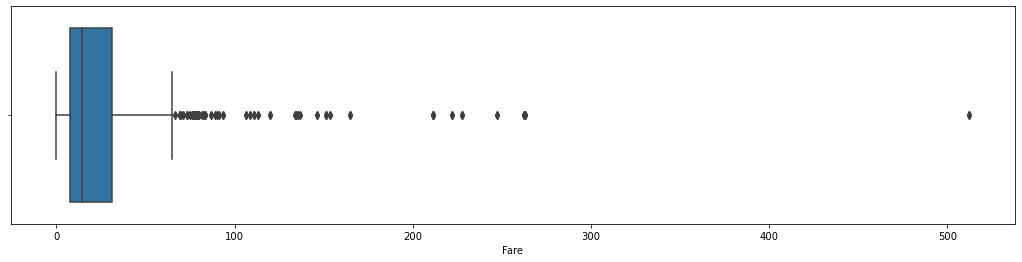

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 4)
sns.boxplot(x="Fare",data=titanic_full).set(xlabel="Fare")

As expected, the distribution is right-skewed. The first reason is that we usually have a lower number of ticket for upper classes (which cost more) in relation to lower classes. That is eventually counter-balanced by the fact that that most of the tickets are sold from the starting port of embark, which are fartest from the destination port, and due to that, cost more. 

So, for this specific feature, we are going to use the median, but considering the class (3) and port of embark (S) for the row.

In [10]:
median_fare = titanic_full[(titanic_full["Pclass"] == 3) & (titanic_full["Embarked"] == "S")]["Fare"].median()
titanic_full["Fare"].fillna(median_fare, inplace=True)
print(check_missing_values())

          percentage_of_missing_values
Embarked                      0.152788
Age                          20.091673
Cabin                        77.463713


Our next feature missing value is Embarked.

In [11]:
titanic_full[titanic_full["Embarked"].isnull()].head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,type_set
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,train
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,train


The two rows (passengers) missing the port of Embark were together, on the same ticket and cabin. For this feature we will assume that they have embarked on the port of origin, which is the mode.

In [12]:
titanic_full["Embarked"].fillna(titanic_full["Embarked"].mode()[0], inplace=True)
print(check_missing_values())

       percentage_of_missing_values
Age                       20.091673
Cabin                     77.463713


Age has more than 20% of rows with null values. Let's take a look on a bunch of them.

In [13]:
titanic_full.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,type_set
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train


Any strategy that we pick here will be an attempt and can go right or not. We decided to go for a strategy of using median, but grouped by Class and Sex, as we can have different medians based on that.

In [14]:
titanic_age_groups = titanic_full[["Pclass", "Sex", "Age"]].groupby(
    ["Pclass", "Sex"]).median().rename(columns={"Age": "age_median"}).reset_index()
titanic_full = pd.merge(titanic_full, titanic_age_groups).set_index("PassengerId").sort_index().reset_index()
titanic_full["Age"].fillna(titanic_full["age_median"], inplace=True)
print(check_missing_values())

       percentage_of_missing_values
Cabin                     77.463713


The only column left is Cabin. Let's take a look on a bunch of records with values and see how they look like.

In [15]:
titanic_full[~titanic_full["Cabin"].isnull()].head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,type_set,age_median
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train,36.0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train,36.0
6,7,0.0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,train,42.0
10,11,1.0,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S,train,22.0
11,12,1.0,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S,train,36.0


Common sense says that the number of cabins should be somehow organized according to its location, which is a potential factor on survival rate. Cabins close to the upper decks or to stairs/elevators might have easy access to safe boats. 

It should be also related to the class. Let's see if we can get some hint by looking on those values.

In [16]:
titanic_full[["Pclass", "Cabin"]].drop_duplicates().head(10)

,Pclass,Cabin
0,3,NaN
1,1,C85
3,1,C123
6,1,E46
9,2,NaN
10,3,G6
11,1,C103
21,2,D56
23,1,A6
27,1,C23 C25 C27


It looks like the lower letters (A, B, C) are usually associated with upper classes. Also, there are rows with multiple values, probably because several adjacent cabins where bought by the same family. 

So, let's make sure we have just one value for each row and then we are going to split the letter from the numbers.

In [17]:
titanic_full["cabin_cleansed"] = titanic_full["Cabin"].str.split(" ").str[-1]
titanic_full["cabin_letter"] = titanic_full["cabin_cleansed"].str[:1]
titanic_full["cabin_number"] = titanic_full["cabin_cleansed"].str[1:] #.astype(int)
titanic_full.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,type_set,age_median,cabin_cleansed,cabin_letter,cabin_number
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train,25.0,NaN,NaN,NaN
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train,36.0,C85,C,85
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train,22.0,NaN,NaN,NaN
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train,36.0,C123,C,123
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train,25.0,NaN,NaN,NaN


We could find some schemas of Titanic on internet, like this cutaway diagram: https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Olympic_%26_Titanic_cutaway_diagram.png/1280px-Olympic_%26_Titanic_cutaway_diagram.png. 

It indicates that the letter on the cabin number represents the decks from the upper (A) to the lowest (G).

Let's rename cabin_letter feature to deck and see if it played any role on survival rate.

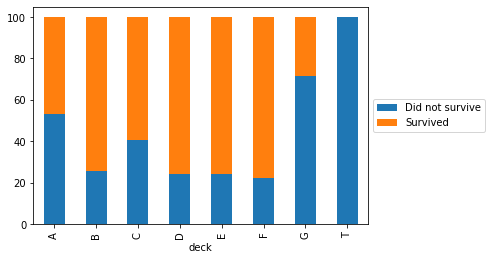

In [18]:
titanic_full = titanic_full.rename(columns={"cabin_letter": "deck"})
titanic_train_transformed = titanic_full[titanic_full["type_set"] == "train"]
pd.crosstab(index=titanic_train_transformed["deck"], columns=titanic_train_transformed["Survived"]) \
    .apply(lambda r: r/r.sum()*100, axis=1) \
    .plot(kind = "bar", stacked=True, mark_right = True, xlabel ="deck") \
    .legend(["Did not survive", "Survived"], loc='center left', bbox_to_anchor=(1.0, 0.5))

We can notice by the plot above that there are higher rates of survival on some decks (B to F) when compared to others (A, G and T). Let's use the strategy of filling null values with mode, for the deck, but we are going to use groups based on Class.

In [19]:
titanic_age_deck = pd.DataFrame(
    titanic_full.groupby("Pclass").deck.apply(lambda x: x.mode())
).rename(columns={"deck": "deck_mode"}).reset_index()[["Pclass", "deck_mode"]]

titanic_full = pd.merge(titanic_full, titanic_age_deck).set_index("PassengerId").sort_index().reset_index()
titanic_full["deck"].fillna(titanic_full["deck_mode"], inplace=True)
print(check_missing_values())

                percentage_of_missing_values
Cabin                              77.463713
cabin_cleansed                     77.463713
cabin_number                       77.463713


In [20]:
titanic_full.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,type_set,age_median,cabin_cleansed,deck,cabin_number,deck_mode
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train,25.0,NaN,G,NaN,G
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train,36.0,C85,C,85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train,22.0,NaN,G,NaN,G
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train,36.0,C123,C,123,C
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train,25.0,NaN,G,NaN,G


For cabin_number feature, let's check the amount of null values per deck and class

In [21]:
missing_cabin_number_per_class_and_deck = titanic_full[titanic_full["cabin_number"].isnull()][["Pclass", "deck"]] \
    .groupby(["Pclass", "deck"]).size().reset_index().rename(columns={0: "empty"})   
total_cabins_per_class_and_deck =  titanic_full[["Pclass", "deck"]] \
    .groupby(["Pclass", "deck"]).size().reset_index().rename(columns={0: "total"})                                      
empty_per_class_and_deck = pd.merge(missing_cabin_number_per_class_and_deck, total_cabins_per_class_and_deck, 
                                    how="outer")
empty_per_class_and_deck["empty"].fillna(0, inplace=True)
empty_per_class_and_deck["percentage"] = empty_per_class_and_deck["empty"] / empty_per_class_and_deck["total"]
empty_per_class_and_deck.sort_values(["Pclass", "deck"])

,Pclass,deck,empty,total,percentage
3,1,A,0.0,22,0.000000
4,1,B,0.0,65,0.000000
0,1,C,67.0,161,0.416149
5,1,D,0.0,40,0.000000
6,1,E,0.0,34,0.000000
7,1,T,0.0,1,0.000000
8,2,D,0.0,6,0.000000
9,2,E,0.0,4,0.000000
1,2,F,254.0,267,0.951311
10,3,E,0.0,6,0.000000


We can see that the lower the deck and the class, the more missing cabin number we have (the outlier here is deck C, class 1). So, as a filling strategy, we are going to use -1 for missing cabin numbers. The we are going to create a feature name cabin_zone, where:

* Cabin numbers -1 will be on cabin_zone N (Neutral)
* Odd cabin numbers (the right side of the boat) will be on cabin_zone O
* Even cabin number (the left side of the boat) will be on cabin_zode E

According to: http://www.paullee.com/titanic/Annotated_Deck_Plans/C_Deck.jpg

In [22]:
titanic_full["cabin_number"] = pd.to_numeric(titanic_full["cabin_number"])
titanic_full["cabin_number"].fillna(-1, inplace=True)
titanic_full["cabin_zone"] = np.where(
    titanic_full["cabin_number"] == -1, "N",
    np.where(titanic_full["cabin_number"] % 2 == 0, "E", "O")
)
titanic_full["cabin_zone"].drop_duplicates()

0    N
1    O
6    E
Name: cabin_zone, dtype: object

Now we can create the encoded features for the position of the cabin, which we are going to call cabin_zone

In [23]:
ohe = OneHotEncoder()
ohe.fit(titanic_full[["cabin_zone"]])
X_ohe = ohe.transform(titanic_full[["cabin_zone"]]).toarray()
ohe_df = pd.DataFrame(
    X_ohe, 
    columns=ohe.get_feature_names(titanic_full[["cabin_zone"]].columns))
titanic_full = pd.concat([titanic_full, ohe_df], axis=1)
titanic_full.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,type_set,age_median,cabin_cleansed,deck,cabin_number,deck_mode,cabin_zone,cabin_zone_E,cabin_zone_N,cabin_zone_O
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train,25.0,NaN,G,-1.0,G,N,0.0,1.0,0.0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train,36.0,C85,C,85.0,C,O,0.0,0.0,1.0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train,22.0,NaN,G,-1.0,G,N,0.0,1.0,0.0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train,36.0,C123,C,123.0,C,O,0.0,0.0,1.0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train,25.0,NaN,G,-1.0,G,N,0.0,1.0,0.0


In [24]:
print(check_missing_values())

                percentage_of_missing_values
Cabin                              77.463713
cabin_cleansed                     77.463713


We are now going to drop cabin_cleansed and fill Cabin with "NA".

In [25]:
titanic_full["Cabin"].fillna("NA", inplace=True)
titanic_full = titanic_full.drop(["cabin_cleansed"], axis=1)
print(check_missing_values())

Empty DataFrame
Columns: [percentage_of_missing_values]
Index: []


Now that we have resolved for missing values for all features and have created new features along the process, let's take a look on other features that are worth of creating new derived features from.

First thing, we are going to create bins for age, and see if they play any role on survival rate. Our bins will be as following: 
* Up to 15 years: Child
* from 16 to 65 years: Adult
* Above 65: Elder

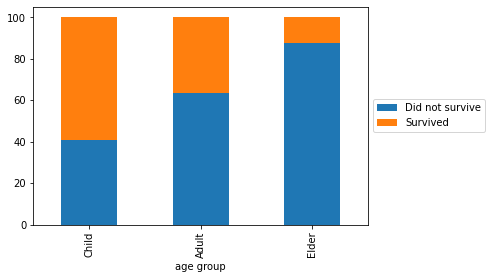

In [26]:
titanic_full["age_group"] = pd.cut(
    x=titanic_full["Age"], 
    bins=[0, 15, 65, 200], 
    labels=["Child", "Adult", "Elder"]
)
titanic_train_transformed = titanic_full[titanic_full["type_set"] == "train"]
pd.crosstab(index=titanic_train_transformed["age_group"], columns=titanic_train_transformed["Survived"]) \
    .apply(lambda r: r/r.sum()*100, axis=1) \
    .plot(kind = "bar", stacked=True, mark_right = True, xlabel ="age group") \
    .legend(["Did not survive", "Survived"], loc='center left', bbox_to_anchor=(1.0, 0.5))

We can see a higher survival rate among children when compared againts adults, which also has a higher survival rate when compared to elders. 

Now let's encode that in features based on each one of the groups. We will do the same for Sex, deck and Port of Embarkment.

In [27]:
ohe = OneHotEncoder()
ohe.fit(titanic_full[["Sex", "Embarked", "age_group", "deck"]])
X_ohe = ohe.transform(titanic_full[["Sex", "Embarked", "age_group", "deck"]]).toarray()
ohe_df = pd.DataFrame(
    X_ohe, 
    columns=ohe.get_feature_names(titanic_full[["Sex", "Embarked", "age_group", "deck"]].columns))
titanic_full = pd.concat([titanic_full, ohe_df], axis=1)
titanic_full.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,type_set,age_median,deck,cabin_number,deck_mode,cabin_zone,cabin_zone_E,cabin_zone_N,cabin_zone_O,age_group,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,age_group_Adult,age_group_Child,age_group_Elder,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NA,S,train,25.0,G,-1.0,G,N,0.0,1.0,0.0,Adult,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train,36.0,C,85.0,C,O,0.0,0.0,1.0,Adult,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NA,S,train,22.0,G,-1.0,G,N,0.0,1.0,0.0,Adult,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train,36.0,C,123.0,C,O,0.0,0.0,1.0,Adult,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NA,S,train,25.0,G,-1.0,G,N,0.0,1.0,0.0,Adult,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Next we are going now to use the two measures that contain the number of relatives travelling with the passenger to create a measure indicating if the person is travelling alone.

In [28]:
titanic_full["relatives"] = titanic_full["SibSp"] + titanic_full["Parch"]
titanic_full["travel_alone"] = np.where(titanic_full["relatives"] == 0, 1, 0)
titanic_full.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,type_set,age_median,deck,cabin_number,deck_mode,cabin_zone,cabin_zone_E,cabin_zone_N,cabin_zone_O,age_group,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,age_group_Adult,age_group_Child,age_group_Elder,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T,relatives,travel_alone
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NA,S,train,25.0,G,-1.0,G,N,0.0,1.0,0.0,Adult,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train,36.0,C,85.0,C,O,0.0,0.0,1.0,Adult,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NA,S,train,22.0,G,-1.0,G,N,0.0,1.0,0.0,Adult,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train,36.0,C,123.0,C,O,0.0,0.0,1.0,Adult,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NA,S,train,25.0,G,-1.0,G,N,0.0,1.0,0.0,Adult,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1


Finally we are going to scale age and fare. We have already created bins for age, but we want also to see if it plays any role.

In [29]:
minmax = MinMaxScaler()
minmax.fit(titanic_full[["Age", "Fare"]])
X_minmax= minmax.transform(titanic_full[["Age", "Fare"]])
minmax_df = pd.DataFrame(
    X_minmax, 
    columns=["Age_scaled", "Fare_scaled"])
titanic_full = pd.concat([titanic_full, minmax_df], axis=1)
titanic_full.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,type_set,age_median,deck,cabin_number,deck_mode,cabin_zone,cabin_zone_E,cabin_zone_N,cabin_zone_O,age_group,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,age_group_Adult,age_group_Child,age_group_Elder,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T,relatives,travel_alone,Age_scaled,Fare_scaled
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NA,S,train,25.0,G,-1.0,G,N,0.0,1.0,0.0,Adult,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0.273456,0.014151
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train,36.0,C,85.0,C,O,0.0,0.0,1.0,Adult,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0.473882,0.139136
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NA,S,train,22.0,G,-1.0,G,N,0.0,1.0,0.0,Adult,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0.323563,0.015469
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train,36.0,C,123.0,C,O,0.0,0.0,1.0,Adult,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0.436302,0.103644
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NA,S,train,25.0,G,-1.0,G,N,0.0,1.0,0.0,Adult,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0.436302,0.015713


Before we start with with our attempts, let's create a function to generate the submissions to Kaggle

In [30]:
def generate_submission(test_set, predictions, name):
    initial_index = test_set.index[0]
    submission = pd.DataFrame({'Survived': predictions}).reset_index()
    submission["Survived"] = submission["Survived"].astype("int32")
    submission["PassengerId"] = submission["index"] + initial_index
    
    file_name = (
        "submission_" + name + "_" + datetime.datetime.today().strftime('%Y%m%d') + 
        '_' + datetime.datetime.today().strftime('%H%M%S') + ".csv"
    )
    submission[["PassengerId", "Survived"]].to_csv(file_name, index=False)  

### First attempt: Decision Tree

For the first attempt we are going to use all features created along with three original features: Pclass, SibSp and Parch

In [31]:
index = ["PassengerId"]
features = [
    "Pclass", "Age_scaled", "SibSp", "Parch", "Fare_scaled", "Sex_female", "Sex_male", "Embarked_C", 
    "Embarked_Q", "Embarked_S", "age_group_Adult", "age_group_Child", "age_group_Elder", "deck_A", "deck_B", 
    "deck_C", "deck_D", "deck_E", "deck_F", "deck_G", "deck_T", "travel_alone"]
label = ["Survived"]
first_attempt_train = titanic_full[titanic_full["type_set"] == "train"][["PassengerId"] + features + label]
first_attempt_test = titanic_full[titanic_full["type_set"] == "test"][["PassengerId"] + features + label]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    first_attempt_train.iloc[:,1:-1],
    first_attempt_train.iloc[:,-1],
    test_size=0.3, random_state=2210)

In [33]:
dt_model = DecisionTreeClassifier(criterion="entropy")
dt_model.fit(X_train, y_train)
predictions = dt_model.predict(X_test) 

In [34]:
precision = precision_score(y_test, predictions)
print('Precision: %f' % precision)
recall = recall_score(y_test, predictions)
print('Recall: %f' % recall)
f1 = f1_score(y_test, predictions)
print("F1-Score: %f" % f1)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %f" % accuracy)
print(classification_report(y_test, predictions, target_names=["Did not survive", "Survived"]))

Precision: 0.752809
Recall: 0.736264
F1-Score: 0.744444
Accuracy: 0.828358
                 precision    recall  f1-score   support

Did not survive       0.87      0.88      0.87       177
       Survived       0.75      0.74      0.74        91

       accuracy                           0.83       268
      macro avg       0.81      0.81      0.81       268
   weighted avg       0.83      0.83      0.83       268



With the decision tree the accuracy is ~0.83 and f1-score ~0.74.

Let's check the confusion matrix.

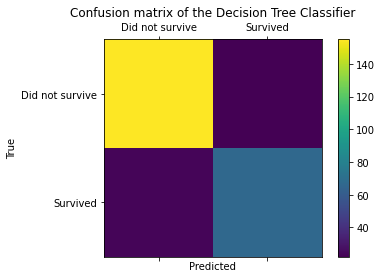

In [35]:
labels = ["Did not survive", "Survived"]
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix(y_test, predictions))
plt.title("Confusion matrix of the Decision Tree Classifier")
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Let's take a look on the first levels of the tree to have an idea what were the most important criteria for spliting.

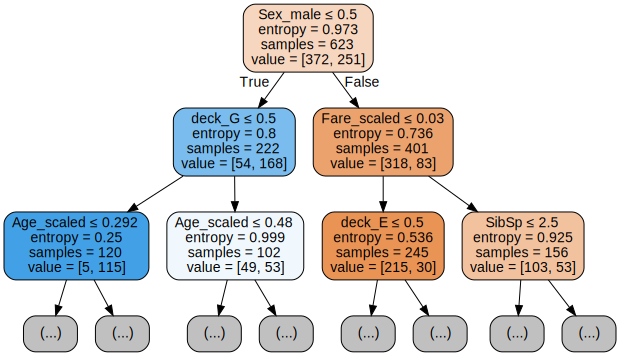

In [36]:
import graphviz
graphviz.Source(export_graphviz(dt_model, out_file=None, filled=True, rounded=True, 
                                special_characters=True, 
                                feature_names=features, max_depth=2))

We can see that our most important criteria for splitting is sex, with an entropy of 0.973. But we can also have some hints that Fare, Deck and Age also played important roles.

Let's generate the prediction and submit to Kaggle.

In [36]:
predictions = dt_model.predict(first_attempt_test.iloc[:,1:-1])
generate_submission(first_attempt_test.set_index("PassengerId"), predictions, "1st_attempt")

The score obtained on Kaggle was 0.73444 which would put us around position 13,100.

### Second attempt: SVM

For the second attempt we are going to use Support Vector Machines with the same features being used so far.

In [37]:
index = ["PassengerId"]
features = [
    "Pclass", "Age_scaled", "SibSp", "Parch", "Fare_scaled", "Sex_female", "Sex_male", "Embarked_C", 
    "Embarked_Q", "Embarked_S", "age_group_Adult", "age_group_Child", "age_group_Elder", "deck_A", 
    "deck_B", "deck_C", "deck_D", "deck_E", "deck_F", "deck_G", "deck_T", "travel_alone"]
label = ["Survived"]
second_attempt_train = titanic_full[titanic_full["type_set"] == "train"][["PassengerId"] + features + label]
second_attempt_test = titanic_full[titanic_full["type_set"] == "test"][["PassengerId"] + features + label]

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    second_attempt_train.iloc[:,1:-1],
    second_attempt_train.iloc[:,-1],
    test_size=0.3, random_state=2210)

We are going to evaluate some combination of SVM parameters and Kernels using Grid Search

In [41]:
param = {
    "kernel": ["linear", "poly", "rbf"],
    "gamma": ["scale", "auto"],
    "degree": [1, 3, 5, 7],
    "C": [0.01, 0.1, 1, 10]
}

In [42]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

svm_model = svm.SVC(random_state=2210)
gs = GridSearchCV(svm_model, param, cv=3, n_jobs=-1, verbose=5, scoring="accuracy")
gs_fit = gs.fit(second_attempt_train[features], second_attempt_train["Survived"])

Fitting 3 folds for each of 96 candidates, totalling 288 fits


In [43]:
pd.DataFrame(gs_fit.cv_results_).sort_values("mean_test_score", ascending=False).head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_degree,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
50,0.017330,0.000778,0.014873,0.000681,1,1,scale,rbf,"{'C': 1, 'degree': 1, 'gamma': 'scale', 'kerne...",0.814815,0.838384,0.835017,0.829405,0.010408,1
56,0.017173,0.000857,0.014428,0.003133,1,3,scale,rbf,"{'C': 1, 'degree': 3, 'gamma': 'scale', 'kerne...",0.814815,0.838384,0.835017,0.829405,0.010408,1
62,0.018973,0.002462,0.015896,0.001731,1,5,scale,rbf,"{'C': 1, 'degree': 5, 'gamma': 'scale', 'kerne...",0.814815,0.838384,0.835017,0.829405,0.010408,1


Our best average accuracy for cross validation with 3 slices was ~0.83. Let's train the model using the parameters above, predict and submit to Kaggle

In [44]:
svmmodel = svm.SVC(kernel="rbf", C=1, gamma="scale", degree=1)
svmmodel.fit(second_attempt_train[features], second_attempt_train["Survived"])

SVC(C=1, degree=1)

In [45]:
predictions = svmmodel.predict(second_attempt_test[features])

In [46]:
generate_submission(second_attempt_test.set_index("PassengerId"), predictions, "3rd_attempt")

Our score on Kaggle for this attemp jumped from 0.73444 (our last attemp using Decision Tree) to 0.78229, around position 2,400.

### Third attempt: XGBooost Classifier

Now we are going to try XGBoost with the same features previously used. We are picking some parameters randomly in this attempt, just to check how it goes.

In [47]:
index = ["PassengerId"]
features = [
    "Pclass", "Age_scaled", "SibSp", "Parch", "Fare_scaled", "Sex_female", "Sex_male", "Embarked_C", 
    "Embarked_Q", "Embarked_S", "age_group_Adult", "age_group_Child", "age_group_Elder", "deck_A", 
    "deck_B", "deck_C", "deck_D", "deck_E", "deck_F", "deck_G", "deck_T", "travel_alone"]
label = ["Survived"]
third_attempt_train = titanic_full[titanic_full["type_set"] == "train"][["PassengerId"] + features + label]
third_attempt_test = titanic_full[titanic_full["type_set"] == "test"][["PassengerId"] + features + label]

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    third_attempt_train.iloc[:,1:-1],
    third_attempt_train.iloc[:,-1],
    test_size=0.3, random_state=2210)

In [49]:
import xgboost as xgb

D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

In [50]:
param = {
    "eta": 0.01, 
    "max_depth": 25,  
    "objective": "multi:softprob", 
    "n_estimators": 1000,
    "early_stopping_rounds": 10,
    'num_class': 2}

steps = 200

In [51]:
xgb_model = xgb.train(param, D_train, steps)

[23:04:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "early_stopping_rounds", "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:04:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [52]:
preds = xgb_model.predict(D_test)
predictions = np.asarray([np.argmax(line) for line in preds])

In [53]:
precision = precision_score(y_test, predictions)
print('Precision: %f' % precision)
recall = recall_score(y_test, predictions)
print('Recall: %f' % recall)
f1 = f1_score(y_test, predictions)
print("F1-Score: %f" % f1)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %f" % accuracy)
print(classification_report(y_test, predictions, target_names=["Did not survive", "Survived"]))

Precision: 0.808989
Recall: 0.791209
F1-Score: 0.800000
Accuracy: 0.865672
                 precision    recall  f1-score   support

Did not survive       0.89      0.90      0.90       177
       Survived       0.81      0.79      0.80        91

       accuracy                           0.87       268
      macro avg       0.85      0.85      0.85       268
   weighted avg       0.87      0.87      0.87       268



Using XGBoost we could improve the accuracy to ~0.87 and f1-score to 0.80. Let's take a look on the tree built and its most important features

**Note**: to zoom in, please, open the image on a new tab.

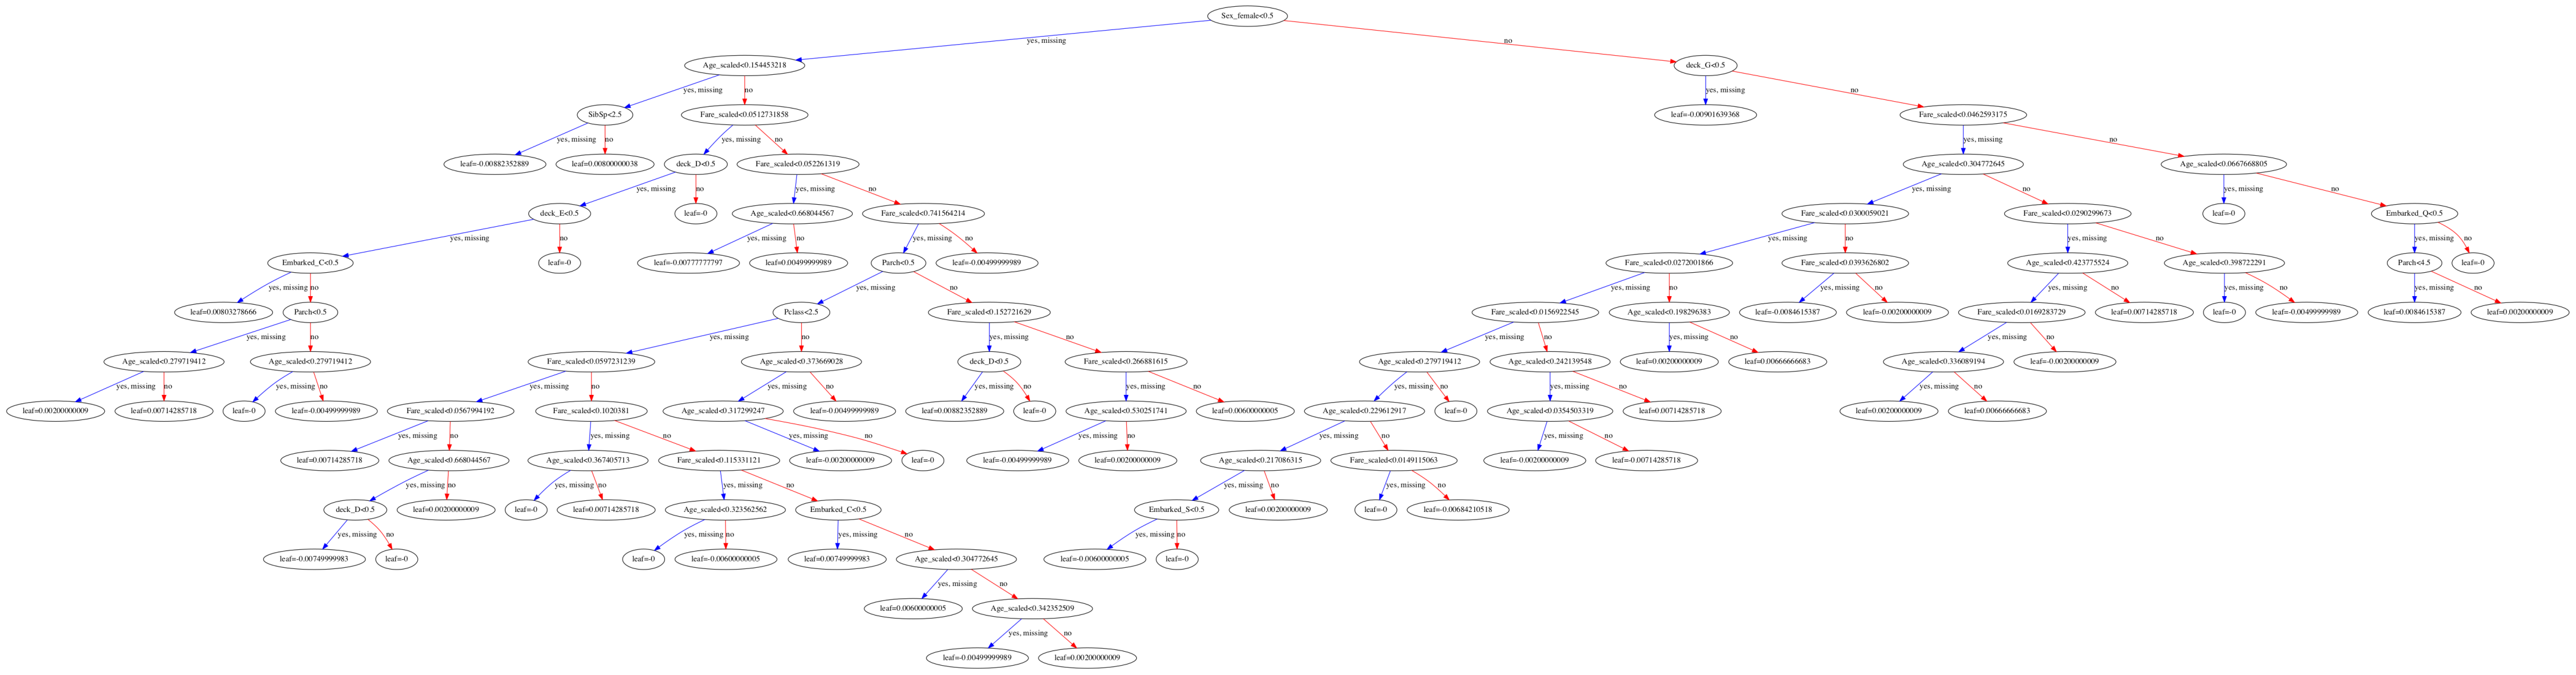

In [54]:
xgb.plot_tree(xgb_model,num_trees=0)
fig = plt.gcf()
fig.set_size_inches(75, 50)

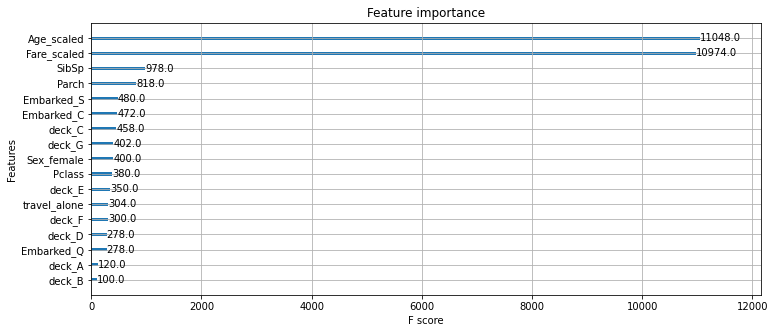

In [55]:
xgb.plot_importance(xgb_model)
fig = plt.gcf()
fig.set_size_inches(12, 5)

We can see that, although our most important feature is Age_scaled, our first splitting criteria is Sex_female.

Let's now convert our test set (the ones with the 418 cases to predict) to a DMatrix, predict and then submit to Kaggle.

In [57]:
validation_set = third_attempt_test.copy()
validation_set.fillna(-1, inplace=True) ## Adding a dummy value for label
validation_set = xgb.DMatrix(validation_set.iloc[:,1:-1], label=validation_set[label])

In [59]:
predictions = xgb_model.predict(validation_set)
predictions = np.asarray([np.argmax(line) for line in predictions])
generate_submission(third_attempt_test.set_index("PassengerId"), predictions, "3rd_attempt")

With the user of XGBoost we could score 0.78947 on Kaggle, which puts us inside the top 10% (below position 1,400).

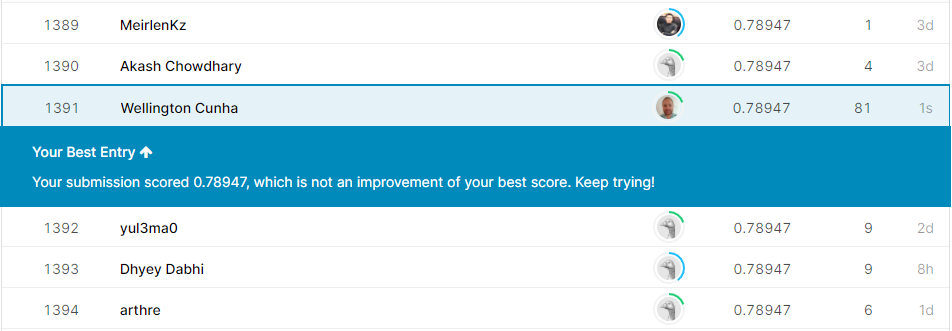

Let's try now to tweak some XGBoost parameters and see if we can increse the accuracy.

### Fourth attempt: tweaking XGBoost hyper-parameters

For this final attempt we still keep using the same features as before.

In [60]:
index = ["PassengerId"]
features = [
    "Pclass", "Age_scaled", "SibSp", "Parch", "Fare_scaled", "Sex_female", "Sex_male", "Embarked_C", 
    "Embarked_Q", "Embarked_S", "age_group_Adult", "age_group_Child", "age_group_Elder", "deck_A", 
    "deck_B", "deck_C", "deck_D", "deck_E", "deck_F", "deck_G", "deck_T", "travel_alone"]
label = ["Survived"]
fourth_attempt_train = titanic_full[titanic_full["type_set"] == "train"][["PassengerId"] + features + label]
fourth_attempt_test = titanic_full[titanic_full["type_set"] == "test"][["PassengerId"] + features + label]

In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    fourth_attempt_train.iloc[:,1:-1],
    fourth_attempt_train.iloc[:,-1],
    test_size=0.3, random_state=2210)
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

In [62]:
param = {
    "eta": 0.015, 
    "max_depth": 25,  
    "objective": "multi:softprob", 
    "n_estimators": 1000,
    "early_stopping_rounds": 10,
    "subsample": 1,
    "colsample_bytree": 1,
    "alpha": 0,
    "lambda": 1,
    "min_child_weight": 1,
    'num_class': 2
}

steps = 175

In [63]:
xgb_model = xgb.train(param, D_train, steps)
preds = xgb_model.predict(D_test)
predictions = np.asarray([np.argmax(line) for line in preds])

[23:06:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "early_stopping_rounds", "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:06:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [64]:
precision = precision_score(y_test, predictions)
print('Precision: %f' % precision)
recall = recall_score(y_test, predictions)
print('Recall: %f' % recall)
f1 = f1_score(y_test, predictions)
print("F1-Score: %f" % f1)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %f" % accuracy)
print(classification_report(y_test, predictions, target_names=["Did not survive", "Survived"]))

Precision: 0.827586
Recall: 0.791209
F1-Score: 0.808989
Accuracy: 0.873134
                 precision    recall  f1-score   support

Did not survive       0.90      0.92      0.91       177
       Survived       0.83      0.79      0.81        91

       accuracy                           0.87       268
      macro avg       0.86      0.85      0.86       268
   weighted avg       0.87      0.87      0.87       268



In [66]:
validation_set = fourth_attempt_test.copy()
validation_set.fillna(-1, inplace=True)
validation_set = xgb.DMatrix(validation_set.iloc[:,1:-1], label=validation_set[label])

In [67]:
predictions = xgb_model.predict(validation_set)
predictions = np.asarray([np.argmax(line) for line in predictions])
generate_submission(fourth_attempt_test.set_index("PassengerId"), predictions, "4th_attempt")

We tried to do small changes on several of the parameters. We could even increase both the accuracy and f1-score when evaluating the predictions using the subset of our train dataset we reserved for that, but even if we could increase both metrics by 1 or 2 points, our submission on Kaggle always scored below our 3rd attempt, which indicates that our model started overfitting.

### Conclusion

Besides the three models (Decision Tree, SVM and XGBoost) outlined on this project, we also did some attempts with other models, frameworks and techniques, such as Logistic Regression, KNN, Random Forest and Keras without success.

Given the fact that there are some submissions on Kaggle leaderboard with over 0.80 of accuracy, probably we would need to work some more on feature enginering (use log for Fare, for instance, or change age_group bin sizes) in order to breach that accuracy.